<a href="https://colab.research.google.com/github/jollygoodjacob/NASA-Space-Apps-Workshop-2024/blob/main/NASA_earthaccess_workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NASA SpaceApps Workshop 2024 - Data Download Tutorial



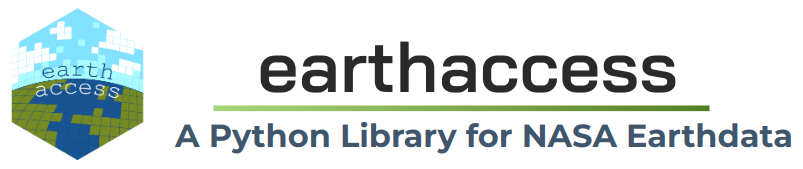

## Downloading NASA spatial datasets from NASA Earthdata
In this tutorial, you will learn how to download NASA datasets through [NASA Earthdata](https://www.earthdata.nasa.gov/) and the [earthaccess Python API](https://github.com/nsidc/earthaccess/). We will demonstrate the earthaccess API's use through an exploration of 30m elevation data from the [Shuttle Radar Topography Mission (SRTM)](https://www.earthdata.nasa.gov/sensors/srtm) over the [Russian River watershed](https://rrwatershed.org/#:~:text=Clean%20Water,%20Habitat%20Restoration%20and%20Watershed%20Enhancement.%20A%20coalition%20of).

We will use the earthaccess library to search for data collections from NASA Earthdata. earthaccess is a Python library that simplifies data discovery and access to NASA Earth science data by providing an abstraction layer for NASA’s Common Metadata Repository (CMR) API Search API. The library makes searching for data more approachable by using a simpler notation instead of low level HTTP queries. earthaccess takes the trouble out of Earthdata Login authentication, makes search easier, and provides a stream-line way to download or stream search results into an xarray object.

For more on earthaccess visit the [earthaccess GitHub page](https://github.com/nsidc/earthaccess/) and/or the [earthaccess documentation site](https://earthaccess.readthedocs.io/en/latest/). Be aware that earthaccess is under active development.

### Sign up for NASA Earthdata
For many of the challenges, NASA Earthdata will be pivotal for obtaining data from NASA that pertains to your challenge. NASA’s Earthdata is your gateway to one of the planet’s largest repositories of Earth observation data. These data – along with the tools for analyzing and working with these data – are available to you fully, openly, and without restriction.

Just follow these simple steps to create an Earthdata Login for yourself.

1. Go to the [Earthdata Login](https://www.earthdata.nasa.gov/eosdis/science-system-description/eosdis-components/earthdata-login) web site, and click on the 'Register' button
2. Enter your information. Only a few fields are mandatory, and these are marked clearly with red dots.
3. Once you have entered your details, click on the green 'Register for Earthdata Login' button at the bottom.
4. To complete the registration, you will now need to go to your email inbox and look for an email similar to the email below. You can activate your account by clicking the activation link provided in the email. Your account must be active before you can login.
5. The link provided in the email should redirect you to NASA Earthdata's activation page. You have now successfully activated your earthdata login account.


### Import required packages
To begin, we need to install a few packages into our Google Colab session prior to running through the tutorial.

In [17]:
!pip install -q earthaccess
!pip install -q rasterio
!pip install -q rioxarray

Next, we will want to import the necessary packages.

In [18]:
# Import Required Packages
import earthaccess
import geopandas as gpd
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import os
import shapely
from shapely.geometry import box
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.crs import CRS
from rasterio.merge import merge
from rasterio.plot import show
import rioxarray as rxr
import matplotlib.colors as colors
import matplotlib.patches as mpatches
from matplotlib.ticker import FuncFormatter

### Prepare a search area

While there are many ways to search for data through the earthaccess API, one effective way to search for data is to predefine an area of interest or study extent. Then, we can search for relevant data to our study.

We can use a combination of geometric operations to obtain a simple outline of our data, which can be used for the search, and to help filter and refine our search results.

First, we’ll load the data using geopandas, making sure to transform from the original CRS to WGS84 latitude/longitude (epsg=4326):

In [19]:
russian_huc8 = gpd.read_file("https://raw.githubusercontent.com/jollygoodjacob/NASA_SpaceApps_Workshop_2024/master/data/russian_huc8.shp").to_crs(epsg=4326)

<ipython-input-20-a1755416d225>:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  outline = russian_huc8['geometry'].unary_union


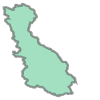

In [20]:
# gets a single polygon (or multipolygon) composed of the individual polygons
outline = russian_huc8['geometry'].unary_union
outline

We often want to simplify our polygon prior to use in NASA Earthdata (or most APIs), as they tend to not like complex geometries.

We can  obtain the spatial extent of the shapefile using the [shapely.bounds](https://shapely.readthedocs.io/en/stable/reference/shapely.bounds.html) command. However, we can also pass a polygon argument. Rather than pass the outline (a very complicated geometric object), though, we’ll look at one additional attribute of a shapely Polygon that we can use to get a bounding box of the geometry - the [minimum_rotated_rectangle](https://shapely.readthedocs.io/en/stable/reference/shapely.minimum_rotated_rectangle.html). Then, from these coordinates, we can create a rectangle that specifies the minimum extent encompassing our shapefile of the Russian River watershed.

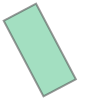

In [21]:
outline.bounds # get the min x, min y, max x, max y values of the polygon

# gets the minimum rotated rectangle that covers the outline
search_area = outline.minimum_rotated_rectangle

search_area # again, in a jupyter notebook, this displays the polygon

The API that earthaccess uses requires that the Polygon be oriented counter-clockwise. To do this, we can use [shapely.geometry.polygon.orient()](https://shapely.readthedocs.io/en/stable/manual.html#shapely.geometry.polygon.orient).

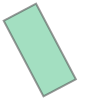

In [22]:
search_area = shapely.geometry.polygon.orient(search_area, sign=1) # a sign of 1 means oriented counter-clockwise

search_area # this doesn't actually change the geometry, just the order of the vertices

Now, we are ready to download some NASA data!

### Searching and Downloading NASA Earthdata Datasets using the earthaccess API

To access NASA data, you have to login using your Earth Data Login credentials. Here, I set the earthaccess login strategy to interactive so that each of you can access NASA Earthdata using your entered username and password.

However, if you are working on your personal computer and you use this API a lot, you probably will want to authenticate using a .netrc file, or through environment variables specifying EARTHDATA_USERNAME and EARTHDATA_PASSWORD.  See [Authenticating](https://earthaccess.readthedocs.io/en/latest/howto/authenticate/) to learn how to create a .netrc file or environment variables, as well as to view all of the options available through the earthaccess.login() command.

We also set the login to persist = True so that we can retain the login information for different code chunks.



In [23]:

auth = earthaccess.login(strategy="interactive", persist=True)

# Thanks to NSIDC for the earthaccess package. See https://github.com/nsidc/earthaccess
# for more details.

#### Data Discovery

We can use the earthaccess API to search for data by querying keywords in a specific area. This can be useful just to get a sense of what might be available.

For more in depth looks at specific data accessible in NASA Earthdata, I recommend several sources (besides those referenced for each individual Challenge):

*   [Earthdata Data Pathfinders](https://www.earthdata.nasa.gov/learn/pathfinders)
*   [LPDAAC](https://lpdaac.usgs.gov/product_search/?status=Operational)
*   [NASA Open Data Portal](https://data.nasa.gov/#:~:text=DATA.NASA.GOV:%20A%20catalog%20of%20publicly%20available%20NASA%20datasets.%20DATA.NASA.GOV%20is)

Below, we will use earthaccess.search_datasets() to discover the number of elevation datasets available over the Russian River.

In [39]:
datasets = earthaccess.search_datasets(
    keyword = "elevation",
    cloud_hosted=True,
     polygon=search_area.exterior.coords#, # search for images that intersect our search_area
)

len(datasets)

290

Wow! That is a lot of elevation data.

While I will be using SRTM data for the rest of the tutorial, it is useful to know there are many potential options, many of which are newer acquisitions with higher spatial resolution than SRTM. However, SRTM is available for most of the globe and is often one of the only datasets available in many locations, which is why I showcase this data here.

#### Data Access

Now, we will want to access the data for download. For this example, we’ll use the following arguments for the search:

**short_name:** the dataset short name. For a full list of available datasets, check the [LPDAAC Data Catalog](https://lpdaac.usgs.gov/product_search/?status=Operational)

**version**: dataset version

**polygon:** a list of (lon, lat) tuples to use for spatial filtering

Other potential inputs include:

**bounding_box:**: You can specify a bounding box instead of a polygon, if you choose

**count:** the maximum number of search results to return

**temporal:** the time frame for which you want to search for data products

To see what additional arguments are available, you can check the GranuleQuery API reference for additional keywords to use, based on the listed methods for the GranuleQuery class.

In [24]:
results = earthaccess.search_data(
    short_name="SRTMGL1",
    version="003",# search for STRM 30m v003 granules
    polygon=search_area.exterior.coords#, # search for images that intersect our search_area
    #count=10 # only show the first 10 results
)

In [25]:
len(results) # show the length of the results list


4

In [26]:
granule = next(iter(results)) # get the "first" item from the list
granule # show the first item

Collection: {'ShortName': 'SRTMGL1', 'Version': '003'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -123.00027778, 'EastBoundingCoordinate': -121.99972222, 'NorthBoundingCoordinate': 39.00027778, 'SouthBoundingCoordinate': 37.99972222}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2000-02-11T00:00:00.000Z', 'EndingDateTime': '2000-02-21T23:59:59.000Z'}}
Size(MB): 11.1448
Data: ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/SRTMGL1.003/N38W123.SRTMGL1.hgt/N38W123.SRTMGL1.hgt.zip']

#### Data Download

Data downloads are very simple. You can either:


1.   Download to a specified path
2.   Obtain download links for each granule

Here, I download the data to Google Colab's temporary storage. If you wish to work with download links instead, see this [documentation](https://earthaccess.readthedocs.io/en/stable/howto/access-data/#:~:text=Option%201:%20Using%20the%20data%20links.%20If%20we%20already%20have).



In [27]:
# Download the data to a specified directory
files = earthaccess.download(results,"/content/srtm")


QUEUEING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/4 [00:00<?, ?it/s]

### Unzipping Data

Oftentimes, the data downloaded from NASA Earthdata is zipped. If we want to work with these datasets, we need to unzip them.

The following script will:

1.) unzip the downloaded data from the directory you saved the data to

2.) Save the full path names to a lsit that we can use to further process the data

In [28]:
# Unzip the downloaded files
unzipped_files = []
for file in files:
    if file.endswith('.zip'):
        with zipfile.ZipFile(file, 'r') as zip_ref:
            # Extract files to the directory of the zip file
            extract_path = os.path.dirname(file)
            zip_ref.extractall(extract_path)

            # Retain full paths of the extracted files
            for extracted_file in zip_ref.namelist():
                # Construct the full file path
                full_path = os.path.join(extract_path, extracted_file)
                unzipped_files.append(full_path)


### Mosaicking Imagery

We have a total of 4 granules over our area of interest, each of which contains continuous elevation data over part of our watershed of interest. However, we probably would like to work with the data as a single, seamless mosaic.

The following code merges the 4 granules into a single seamless mosaic to work with.

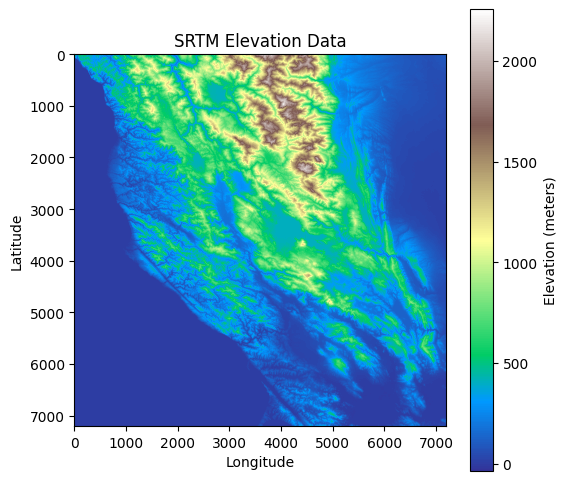

In [29]:
# Mosaic all the GeoTIFF files
src_files_to_mosaic = []

for hgt_file in unzipped_files:
    if hgt_file.endswith('.hgt'):
        src = rio.open(hgt_file)
        src_files_to_mosaic.append(src)

# Merge all the files
mosaic, out_trans = rio.merge.merge(src_files_to_mosaic)

#Plot the mosaicked imagery
plt.figure(figsize=(6, 6))
plt.title("SRTM Elevation Data")
plt.imshow(mosaic[0], cmap='terrain')
plt.colorbar(label='Elevation (meters)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Copy metadata from one of the source rasters
out_meta = src_files_to_mosaic[0].meta.copy()

# Update metadata to match the mosaic dimensions and transformation
out_meta.update({
    "driver": "GTiff",
    "height": mosaic.shape[1],
    "width": mosaic.shape[2],
    "transform": out_trans
})

# Write the mosaic to disk
with rio.open("/content/mosaic.tif", "w", **out_meta) as dest:
    dest.write(mosaic)


### Reproject and Crop Imagery to Study Area

We often want to clip these mosaics to our area of interest, as it reduces the overhead on subsequent raster processing and also makes our data map ready for our study area.

However, before we do this, we need to make sure our SRTM data has the same coordinate reference system as the Russian River watershed polygon, else the cropping operation will fail.

Let's perform this coordinate projection task. Here, I use the helpful functionality of rioxarray, which performs these reprojection and clipping operations with much less hassle than using rasterio. Rioxarray simply adds xarray functionality to rasterio.

In [30]:
# Load the raster into an xarray DataArray
raster = rioxarray.open_rasterio("/content/mosaic.tif")

# Reproject to a new CRS (e.g., EPSG:4326)
reprojected_raster = raster.rio.reproject("EPSG:4326")

# Save the reprojected raster
reprojected_raster.rio.to_raster('reprojected_mosaic.tif')


Neat! An insidious spatial issue averted through the use of only several lines of code.

When working with spatial datasets, one of the primary challenges people tend to run into are unaligned spatial datasets. Ensuring your coordinate reference system for each dataset are the same and applying the appropriate transformations when they are not will save you lots of time and hassle.

Ok, now let's clip our dataset to our region of interest!

In [31]:
# Load the raster into an xarray DataArray using rioxarray
raster = rioxarray.open_rasterio("/content/reprojected_mosaic.tif")

# Load the shapefile (in EPSG:4326) defining the study area
study_area_gdf = gpd.read_file("https://raw.githubusercontent.com/jollygoodjacob/NASA_SpaceApps_Workshop_2024/master/data/russian_huc8.shp").to_crs(epsg=4326)

# Clip the raster using the shapefile's geometry
# Note: we need to pass the geometry from the GeoDataFrame
clipped_raster = reprojected_raster.rio.clip(study_area_gdf.geometry.apply(lambda x: x.__geo_interface__))

# Save the clipped raster to a new file
clipped_raster.rio.to_raster('clipped_mosaic.tif')






Finally, let's visualize our results with a map!

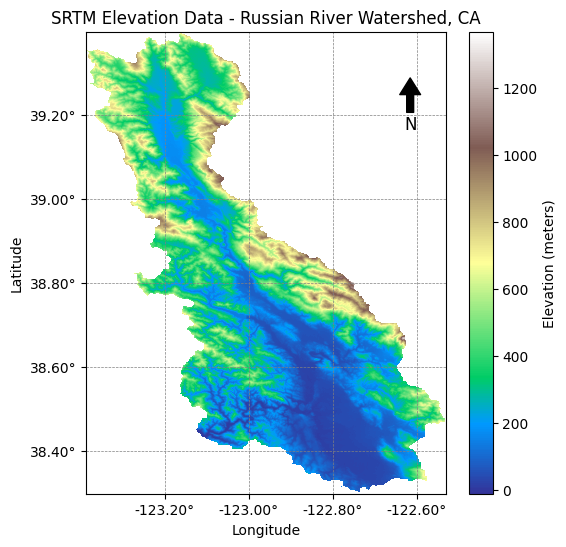

In [32]:
clipped_raster = rioxarray.open_rasterio("/content/clipped_mosaic.tif",masked=True)

# Get the extent of the raster (left, right, bottom, top) to set the coordinate system
extent = [
    clipped_raster.rio.bounds()[0],  # left
    clipped_raster.rio.bounds()[2],  # right
    clipped_raster.rio.bounds()[1],  # bottom
    clipped_raster.rio.bounds()[3],  # top
]

# Function to add degree symbol to the grid coordinates
def degree_formatter(x, pos):
    return f'{x:.2f}°'

plt.figure(figsize=(6, 6))
plt.title("SRTM Elevation Data - Russian River Watershed, CA")
plt.imshow(clipped_raster[0], cmap='terrain', extent=extent)
plt.colorbar(label='Elevation (meters)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Format the tick labels to include the degree symbol
ax = plt.gca()
ax.xaxis.set_major_formatter(FuncFormatter(degree_formatter))
ax.yaxis.set_major_formatter(FuncFormatter(degree_formatter))

# Show gridlines for better visual reference of coordinates
plt.grid(True, which='both', color='gray', linestyle='--', linewidth=0.5)

# Add a north arrow annotation in the top-right corner
ax.annotate('N', xy=(0.9, 0.9), xytext=(0.9, 0.8),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=12, xycoords='axes fraction')

plt.show()

## Conclusion

In this tutorial, we have:

*   Created a NASA Earthdata Account
*   Uploaded a searchable area for acquiring NASA datasest
*   Logged into NASA Earthdata through the API
*   Searched for data relevant to our project
*   Downloaded the data
*   Mosaicked the data over the study area
*   Projected all data to a common coordinate reference system
*   Clipped the data to our study area
*   Created a finalized map of the data


This tutorial covers much of the basic steps to begin working with NASA earth observation datasets. You will likely need to perform some or all of these steps in your specific challenges, so we hope this tutorial provides a starting place to reference for your challenges.
